In [ ]:
Open and merge into a NetCDF file the Gap-filled Fractional Snow Cover (GFSC) downloaded from WEkEO

In [48]:
# Import libraries
import xarray as xr
import rioxarray as rxr
import os
import zipfile
import matplotlib.pyplot as plt
from pyproj import CRS

In [46]:
# Functions

def unzip(path: str) -> None:
    """
    Unzip files
    """
    for z in os.listdir(path):
        if z.endswith('.zip'):
            zip_name = path + "/" + z
            zip_ref = zipfile.ZipFile(zip_name)
            zip_ref.extractall(path)
            zip_ref.close()

def cut_common_prefix(string_list: list) -> list:
    """
    Cut common prefix in a list of strings
    """
    common_prefix = ""
    for j in range(1, len(string_list)):
        if j == 1:
            string1 = string_list[0]
        else:
            string1 = common_prefix
            common_prefix = ''
        string2 = string_list[j]
        for i in range(min(len(string1), len(string2))):
            if string1[i] == string2[i]:
                common_prefix += string1[i]
            else:
                pass

    return [elem[len(common_prefix):] for elem in string_list]

def cut_common_suffix(string_list: list) -> list:
    """
    Cut common suffix in a list of strings
    """
    inverted_list = [el[::-1] for el in string_list]
    inverted_list_wo_prefix = cut_common_prefix(inverted_list)
    return [el[::-1] for el in inverted_list_wo_prefix]
    
def create_netcdf_from_tiffs(path: str) -> xr.Dataset:
    """
    Create xr.Dataset and return the NetCDF. Only .tiff files are incorporated into the NetCDF.
    """
    try:
        print('Merging the tiff images in a NetCDF file')
        string_list = os.listdir(path)
        string_list = [f for f in string_list if '.tif' in f]

        variables_list = cut_common_suffix(cut_common_prefix(string_list))
        ds = xr.Dataset()
        for i in range(len(string_list)):
            da = (rxr.open_rasterio(f"{path}/{string_list[i]}").drop(['spatial_ref', 'band']).squeeze('band'))
            ds[variables_list[i]] = da
        ds = ds.rio.write_crs(rxr.open_rasterio(f"{path}/{string_list[i]}").rio.crs)

    except FileNotFoundError:
        print('Returning an empty xr.Dataset')
        ds = xr.Dataset()

    return ds

Merging the tiff images in a NetCDF file


Do you want to select a Region of Interest (if yes, type 'y'):  y
Please insert the minimum latitude (in decimal degrees):  44.4
Please insert the maximum latitude (in decimal degrees):  44.8
Please insert the minimum longitude (in decimal degrees):  4.8
Please insert the maximum longitude (in decimal degrees):  5.43


Saving the GFSC map as WEkEO_Sentinel-2_GFSC.nc


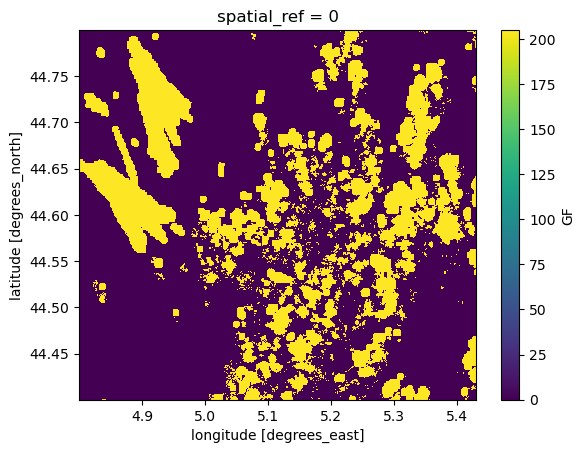

In [50]:
# Unzip WEKEO downloaded GFSC products
var = 'GF'
zip_path = '/home/federico/Jupyter_Notebooks/WEkEO_GFSC_sample/' 
unzip(zip_path)

# Create NetCDF from the downloaded GFSC products
gfsc_folder = '/home/federico/Jupyter_Notebooks/WEkEO_GFSC_sample/GFSC_20171001-007_S1-S2_T31TFK_V101_1640094009'
ds = create_netcdf_from_tiffs(gfsc_folder)

# Transform coordinates in the World Geodetic System (WGS-84; EPSG:4326)
ds = ds.rio.reproject(CRS("WGS84"), nodata=255)

# Cut image over a selected area if requested by the user
roi = input("Do you want to select a Region of Interest (if yes, type 'y'): ")

if roi == 'y':
    lat_min = float(input("Please insert the minimum latitude (in decimal degrees): "))
    lat_max = float(input("Please insert the maximum latitude (in decimal degrees): "))
    lon_min = float(input("Please insert the minimum longitude (in decimal degrees): "))
    lon_max = float(input("Please insert the maximum longitude (in decimal degrees): "))
    ds = ds.where((ds.x <= lon_max) & (ds.x >= lon_min) & (ds.y <= lat_max) & (ds.y >= lat_min), drop=True)

# Plot the image in the selected area
plt.figure()
ds[var].plot()

# Save the final GFSC map
save_name = 'WEkEO_Sentinel-2_GFSC.nc'
netcdf_encoding = {var: {'dtype': 'uint8', 'zlib': True, 'complevel': 5} for var in ds.data_vars}
print(f"Saving the GFSC map as '{save_name}'")
ds.to_netcdf(save_name, engine="netcdf4", encoding=netcdf_encoding)